<a href="https://colab.research.google.com/github/YasirHabib/Deep-Learning-Advanced-Computer-Vision/blob/master/fruits_360_vgg_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [0]:
from glob import glob

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
# https://www.kaggle.com/moltean/fruits
path = '/content/gdrive/My Drive/Colab Notebooks/Deep Learning: Advanced Computer Vision/fruits-360/'

In [0]:
train_dir = os.path.join(path, 'Training')
validation_dir = os.path.join(path, 'Test')

# train_apple_dir = os.path.join(train_dir, 'Apple Golden 1')
# train_avocado_dir = os.path.join(train_dir, 'Avocado')
# train_banana_dir = os.path.join(train_dir, 'Banana')
# train_kiwi_dir = os.path.join(train_dir, 'Kiwi')
# train_lemon_dir = os.path.join(train_dir, 'Lemon')
# train_mango_dir = os.path.join(train_dir, 'Mango')
# train_raspberry_dir = os.path.join(train_dir, 'Raspberry')
# train_strawberry_dir = os.path.join(train_dir, 'Strawberry')

# validation_apple_dir = os.path.join(validation_dir, 'Apple Golden 1')
# validation_avocado_dir = os.path.join(validation_dir, 'Avocado')
# validation_banana_dir = os.path.join(validation_dir, 'Banana')
# validation_kiwi_dir = os.path.join(validation_dir, 'Kiwi')
# validation_lemon_dir = os.path.join(validation_dir, 'Lemon')
# validation_mango_dir = os.path.join(validation_dir, 'Mango')
# validation_raspberry_dir = os.path.join(validation_dir, 'Raspberry')
# validation_strawberry_dir = os.path.join(validation_dir, 'Strawberry')

In [0]:
num_apple_train = len(glob(train_dir + '/Apple Golden 1/*.jp*g'))
num_avocado_train = len(glob(train_dir + '/Avocado/*.jp*g'))
num_banana_train = len(glob(train_dir + '/Banana/*.jp*g'))
num_kiwi_train = len(glob(train_dir + '/Kiwi/*.jp*g'))
num_lemon_train = len(glob(train_dir + '/Lemon/*.jp*g'))
num_mango_train = len(glob(train_dir + '/Mango/*.jp*g'))
num_raspberry_train = len(glob(train_dir + '/Raspberry/*.jp*g'))
num_strawberry_train = len(glob(train_dir + '/Strawberry/*.jp*g'))

num_apple_validation = len(glob(validation_dir + '/Apple Golden 1/*.jp*g'))
num_avocado_validation = len(glob(validation_dir + '/Avocado/*.jp*g'))
num_banana_validation = len(glob(validation_dir + '/Banana/*.jp*g'))
num_kiwi_validation = len(glob(validation_dir + '/Kiwi/*.jp*g'))
num_lemon_validation = len(glob(validation_dir + '/Lemon/*.jp*g'))
num_mango_validation = len(glob(validation_dir + '/Mango/*.jp*g'))
num_raspberry_validation = len(glob(validation_dir + '/Raspberry/*.jp*g'))
num_strawberry_validation = len(glob(validation_dir + '/Strawberry/*.jp*g'))

total_train = len(glob(train_dir + '/*/*.jp*g'))
total_validation = len(glob(validation_dir + '/*/*.jp*g'))

print('total training apple images:', num_apple_train)
print('total training avocado images:', num_avocado_train)
print('total training banana images:', num_banana_train)
print('total training kiwi images:', num_kiwi_train)
print('total training lemon images:', num_lemon_train)
print('total training mango images:', num_mango_train)
print('total training raspberry images:', num_raspberry_train)
print('total training strawberry images:', num_strawberry_train)
print("")
print('total validation apple images:', num_apple_validation)
print('total validation avocado images:', num_avocado_validation)
print('total validation banana images:', num_banana_validation)
print('total validation kiwi images:', num_kiwi_validation)
print('total validation lemon images:', num_lemon_validation)
print('total validation mango images:', num_mango_validation)
print('total validation raspberry images:', num_raspberry_validation)
print('total validation strawberry images:', num_strawberry_validation)
print("")
print("Total training images:", total_train)
print("Total validation images:", total_validation)

# useful for getting number of classes
folders = glob(train_dir + '/*')

# look at an image for fun
# plt.imshow(image.load_img(np.random.choice(image_files)))
# plt.show()

total training apple images: 492
total training avocado images: 427
total training banana images: 490
total training kiwi images: 466
total training lemon images: 492
total training mango images: 399
total training raspberry images: 490
total training strawberry images: 492

total validation apple images: 164
total validation avocado images: 143
total validation banana images: 166
total validation kiwi images: 156
total validation lemon images: 164
total validation mango images: 166
total validation raspberry images: 166
total validation strawberry images: 164

Total training images: 3748
Total validation images: 1289


In [0]:
# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs = 5
batch_size = 32

In [0]:
# image_gen_train is an instance of ImageDataGenerator. The arguments tell the generator the ways in which its allowed to modify the data (images)
image_gen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

image_gen_val = ImageDataGenerator(preprocessing_function=preprocess_input)  # Generator for our validation data

In [0]:
# create generators
train_generator = image_gen_train.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
)

valid_generator = image_gen_val.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
)

Found 3748 images belonging to 8 classes.
Found 1289 images belonging to 8 classes.


In [0]:
valid_generator = image_gen_val.flow_from_directory(validation_dir, target_size=IMAGE_SIZE)
print(valid_generator.class_indices)                    # function class_indices returns a dictionary where key is the class name & the value is class index

Found 1289 images belonging to 8 classes.
{'Apple Golden 1': 0, 'Avocado': 1, 'Banana': 2, 'Kiwi': 3, 'Lemon': 4, 'Mango': 5, 'Raspberry': 6, 'Strawberry': 7}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


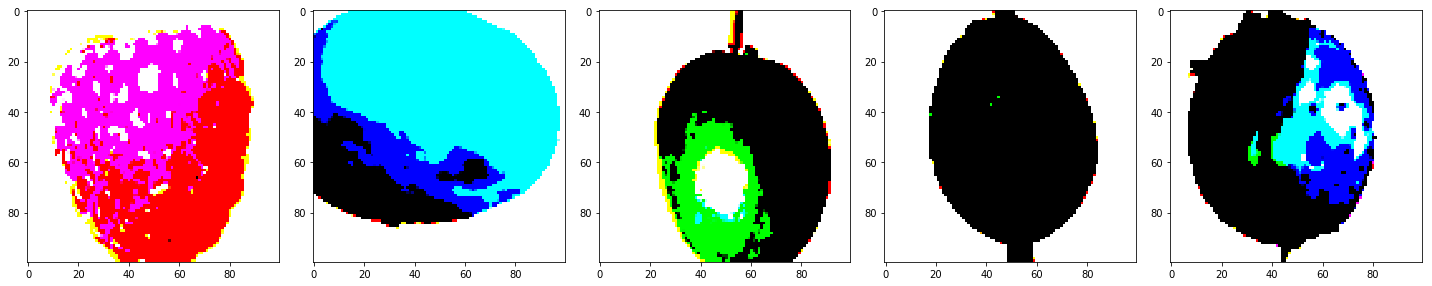

In [0]:
# The data should be preprocessed properly. This has been done by passing (preprocessing_function=preprocess_input) above which reorders the channels from RGB to BGR
# should be a strangely colored images (due to VGG weights being BGR)
sample_training_images, _ = next(train_generator)
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:5])       # Plot images 0-4

In [0]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)


# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# tell the model what cost and optimization method to use
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [0]:
# view the structure of the model
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

In [0]:

# fit the model
r = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch = total_train // batch_size,
    validation_steps = total_validation // batch_size
)

Epoch 1/5
117/117 [==============================] - 15s 129ms/step - loss: 4.5653 - acc: 0.7046 - val_loss: 3.8408 - val_acc: 0.7617
Epoch 2/5
117/117 [==============================] - 15s 128ms/step - loss: 2.2032 - acc: 0.8598 - val_loss: 1.8208 - val_acc: 0.8870
Epoch 3/5
117/117 [==============================] - 15s 131ms/step - loss: 1.8458 - acc: 0.8843 - val_loss: 1.7695 - val_acc: 0.8902
Epoch 4/5
117/117 [==============================] - 15s 129ms/step - loss: 1.8401 - acc: 0.8857 - val_loss: 1.8336 - val_acc: 0.8862
Epoch 5/5
117/117 [==============================] - 15s 125ms/step - loss: 1.8434 - acc: 0.8851 - val_loss: 1.7952 - val_acc: 0.8886


In [0]:
def get_confusion_matrix(data_path, total, gen):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", total)
  predictions = []
  targets = []
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= total:
      break

  cm = confusion_matrix(targets, predictions)
  return cm


cm = get_confusion_matrix(train_dir, total_train, image_gen_train)
print(cm)
valid_cm = get_confusion_matrix(validation_dir, total_validation, image_gen_val)
print(valid_cm)

Generating confusion matrix 3748
Found 3748 images belonging to 8 classes.
[[492   0   0   0   0   0   0   0]
 [  0   0   0  88   0 336   0   3]
 [  0   0 490   0   0   0   0   0]
 [  0   0   0 466   0   0   0   0]
 [  0   0   0   0 492   0   0   0]
 [  0   0   0   0   0 399   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]
Generating confusion matrix 1289
Found 1289 images belonging to 8 classes.
[[164   0   0   0   0   0   0   0]
 [  0   0   0  42   0 101   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0 166   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


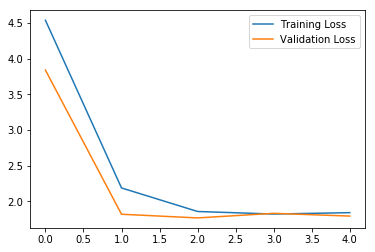

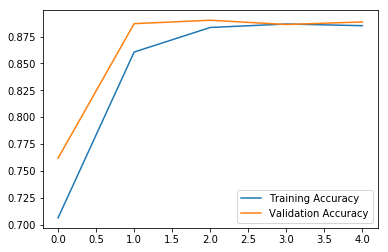

In [0]:
# plot some data

# loss
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='Training Accuracy')
plt.plot(r.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.show()